In [1]:
# Kwatra's texture optimization with pytorch
# Julien.Rabin@unicaen.fr 2020
# Exercice : complete this code (see block #4)!

In [2]:
# import packages
%matplotlib inline

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time


import os
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print('USE CUDA')
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'
    #torch.cuda.set_device(1)
    #torch.cuda.device(0)
    device = torch.device('cuda:0')
    # torch.cuda.current_device()
else :
    dtype = torch.FloatTensor
    device = torch.device('cpu')


USE CUDA


In [3]:
# Fonctions utiles pour l'algorithme

def Tensor_display(img_torch) : # display images coded as torch tensor
    img_np = img_torch.squeeze(0).permute(1, 2, 0).cpu().numpy() #is an array, shaped as an image for plt with permute

    plt.figure()
    plt.imshow(img_np, interpolation="bicubic")
    plt.show()

def Tensor_display_ax(img_torch, ax):
    img_np = img_torch.squeeze(0).permute(1, 2, 0).cpu().numpy() #is an array, shaped as an image for plt with permute
    ax.imshow(img_np, interpolation="bicubic")
    
def Tensor_load(file_name) : # load an image as a torch tensor : BATCHSIZE=1 x COLOR=3 x Width x Height
    img_np0 = plt.imread(file_name)
    if img_np0.max()>1 : # normalization pour corriger un bug entre PNG (dans [0,1]) et JPG (dans [0,255])
        img_np0 = img_np0/img_np0.max()

    img_torch = torch.tensor(img_np0, dtype = torch.float, device=device, requires_grad = False).permute(2, 0, 1).unsqueeze(0)
    return img_torch

## patch nearest neighbor search
def Patch_NN_search(P_exmpl, P_synth, N_subsampling) :
    N = P_exmpl.size(2)
        
    ## precomputation for NN search
    Ns = np.min([N_subsampling,N])
    
    I = torch.randperm(N)#.to(device)
    I = I[0:Ns]
    X = P_exmpl[:,:,I] #.to(device) # 1 x d x Ns
    X = X.squeeze(0) # d x Ns
    X2 = (X**2).sum(0).unsqueeze(0) # 1 x Ns

    ## NN SEARCH
    Y = P_synth.squeeze(0) # d x N
    Y2 = (Y**2).sum(0).unsqueeze(0) # squared norm : 1 x N
    D = Y2.transpose(1,0) - 2 * torch.matmul(Y.transpose(1,0),X) + X2
    
    
    J = torch.argmin(D,1)
    #P_synth = P_exmpl[:,:,I[J]] # patch matching
    P_synth = X[:,J].unsqueeze(0) # same
    
    D = torch.min(D,1)[0] # squared distance
    return P_synth, D

## extract patch from an image
def Patch_extraction(img_torch, patchsize, stride) :
    P = torch.nn.Unfold(kernel_size=patchsize, dilation=1, padding=0, stride=stride)(img_torch) # Tensor with dimension 1 x 3*Patchsize^2 x Heigh*Width/stride^2
    return P

## patch aggregation into an image by weighted averaging
def Patch_Average(P_synth, patchsize, stride, W, H, r, D) : 
    # r = 0.8 in Kwatra
    
    if r==2 : # simple average with L2^2 distance
        synth = nn.Fold((W,H), patchsize, dilation=1, padding=0, stride=stride)(P_synth)
        count = nn.Fold((W,H), patchsize, dilation=1, padding=0, stride=stride)(P_synth*0+1)

    else : # weighted average using least square reweighting
        count = torch.pow(torch.max(D,torch.zeros_like(D)+1e-8), (r-2.)/2.)
        count = count.view(1,1,-1).repeat(1,P_synth.size(1),1)

        D = torch.pow(torch.max(D,torch.zeros_like(D)), r/2)

        synth = nn.Fold((W,H), patchsize, dilation=1, padding=0, stride=stride)(P_synth * count)
        count = nn.Fold((W,H), patchsize, dilation=1, padding=0, stride=stride)(count)

    synth = synth / count
    return synth


## synthesis initialization
def initialization(img_torch, block_size = 1) :
    if block_size==1 : # random init by permuting color pixel
        synth = torch.clone(img_torch)

        synth = synth.view(1,3,-1)
        tmp   = img_torch.view(1,3,-1)
        I = torch.randperm(tmp.size(2))
        synth[0,0,:] = tmp[0,0,I]
        synth[0,1,:] = tmp[0,1,I]
        synth[0,2,:] = tmp[0,2,I]

        synth = synth.view(img_torch.size())

    else : # random permutation of patchs (à la manière d'un taquin)
        size_init = block_size
        stride_init = size_init # size_init//2 # patch sans superposition si egal a size_init

        # 
        P_synth = torch.nn.Unfold(kernel_size=size_init, dilation=1, padding=0, stride=stride_init)(img_torch)
        P_synth = P_synth[:,:,torch.randperm(P_synth.size(2))]
        synth = nn.Fold((img_torch.size(2), img_torch.size(3)), size_init, dilation=1, padding=0, stride=stride_init)(P_synth)

        count = nn.Fold((img_torch.size(2), img_torch.size(3)), size_init, dilation=1, padding=0, stride=stride_init)(P_synth*0+1)
        synth = synth / count
        
    return synth

In [4]:
'''Compléter ce code en utilisant exclusivement les fonctions déjà définies '''

def TextureOptimization(img_torch0,N_subsampling) :
    
    loss = np.array([]);
    Iter = 0;

    ## Algorithm
    for it_scale,scale in enumerate(scale_size) :
        #print('@ scale = ', it_scale, ' with resolution = ', scale)

        ## downsample input image 
        img_torch = F.interpolate(img_torch0, size=(scale), scale_factor=None, mode='bicubic', align_corners=False).clamp(0,1)
        if PLOT: Tensor_display(img_torch)


        ## INIT
        ''' Initialisation de l'image à synthétiser  '''
        if(it_scale == 0 ):
            img_synth = initialization(img_torch, 8)
        else:
            img_synth = F.interpolate(img_synth, size=(scale), scale_factor=None, mode='bicubic', align_corners=False).clamp(0,1)

        for it_patch,patchsize in enumerate(patch_size[it_scale]) :    
            #print('... @ patch resolution = ', it_patch, ' with patch size = ', patchsize)    
            stride = patchsize//4 # patch stride
            #patchdim = patchsize**2*3 # patch dim

            ## Patch extraction
            p_exmpl = Patch_extraction(img_torch, patchsize, stride)
        
            # Mono-scale ALGORITHM
            for it in range(niter):
                Iter = Iter+1;
                #print('iter = ', Iter)

                ## Patch extraction
                ''' extraire patch de l'image de synthese  '''
                p_synth = Patch_extraction(img_synth, patchsize, stride)

                ## NN SEARCH
                ''' mise en correspondance des patchs '''
                p_synth, D = Patch_NN_search(p_exmpl, p_synth, N_subsampling)

                ## patch Aggregation
                ''' recomposer une image en utilisant les patchs choisis  '''
                img_synth = Patch_Average(p_synth, patchsize, stride, img_torch.shape[2], img_torch.shape[3], 0.8, D)

                ## print loss
                ''' extraire patch d'exemple 
                L = distance moyenne entre patch
                loss = np.append(loss, L.cpu().numpy() ) # for display after optimization
                print('loss [', Iter, '] = ',loss[-1])
                '''
                L = D.sum()
                loss = np.append(loss, L.cpu().numpy() )
                #print('loss [', Iter, '] = ',loss[-1])


                ## Plot image
                if PLOT and it%5==0 : Tensor_display(synth)
    return img_synth, loss

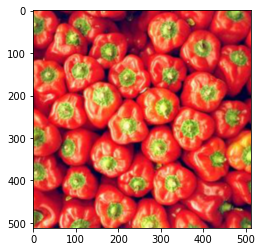

In [7]:
imsize = 512 # 128 # 256 # 512 : desired input/output resolution
BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here


# Load a texture image
data_rep = 'textures/'
save_rep = 'results/'

im_name = 'red-peppers256.jpg'   #'rafia-2.jpg'  'raad1.png' 'raad8.png'  'radishes.jpg' 'red-peppers256.jpg' 

file_name = data_rep + im_name

## load image as a Tensor
img_torch = Tensor_load(file_name)
img_torch0 = torch.clone(img_torch)

## resize (required for large images)
img_torch = nn.functional.adaptive_avg_pool2d(img_torch, imsize)

C = img_torch.size(1) # channel dim = 3
W = img_torch.size(2) # width
H = img_torch.size(3) # height

# display image
Tensor_display(img_torch)



Elapsed time :  8.153693437576294  seconds


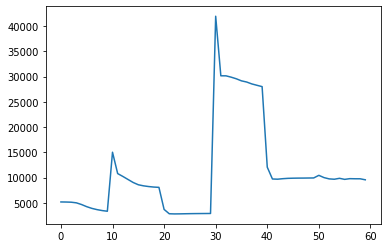

In [8]:
# Texture optimization algorithm (multi-scale)
PLOT = False #True / False
niter = 10 # iter per scale and per patch size, Default: 10

N_subsampling = int(10000) # random sampling of patch in the input image to reduce the memory footprint
scale_size = [64, 128, 256] # Default: [128, 256, 512], [64, 128, 256]
patch_size = [[8],[16, 8],[32, 16, 8]] # [[8],[8],[8]]  Default: [[8],[16, 8],[32, 16, 8]]

t0 = time.time()
synth,loss = TextureOptimization(img_torch0,N_subsampling) 
t0 = time.time()-t0      
print('Elapsed time : ', t0, ' seconds')

# loss plot    
fig = plt.figure()
plt.plot(loss)
plt.show()

input


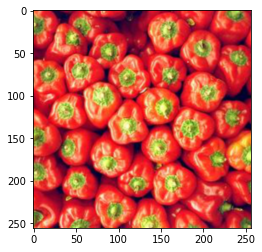

output


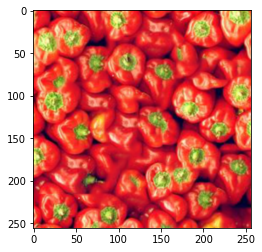

In [9]:
print('input')
Tensor_display(img_torch0)
print('output')
Tensor_display(synth)

In [18]:
from patchmatch import MappingUtils
from patchmatch import PatchMatchLib
from patchmatch import PatchMatchGPU
import torchvision
image = torchvision.transforms.ToPILImage()(synth.cpu()[0])
reference = torchvision.transforms.ToPILImage()(img_torch0.cpu()[0])
offsets2, mapping2 = PatchMatchGPU.patch_match(image, reference, patch_size=8, iterations=5, dtresh=0.01, initialization=None, itresh=None, device=None)
image2 = MappingUtils.reconstruct(reference, mapping2)
offsets_color = MappingUtils.colormap(offsets2)
torchvision.utils.save_image(torchvision.transforms.ToTensor()(offsets_color),'mappingPatch.jpg',normalize=True)

In [ ]:
# save image
img_torch = F.interpolate(img_torch0, size=(synth.size(2),synth.size(3)), scale_factor=None, mode='bicubic', align_corners=False).clamp(0,1)
out = torch.cat((img_torch,synth), 3) # put in and out side by side
out = out.squeeze(0).permute(1, 2, 0).cpu().numpy()
plt.imsave('out.png', out)

In [ ]:
import os

def calculateAll():
  imsize = 1024 # 128 # 256 # 512 : desired input/output resolution
  BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here

  # Load a texture image
  data_rep = 'textures/'
  save_rep = 'results/'

#  im_name = 'red-peppers256.jpg'   #'rafia-2.jpg'  'raad1.png' 'raad8.png'  'radishes.jpg' 'red-peppers256.jpg' 
  for im_name in os.listdir(data_rep):
    print("Processing " + im_name)
    file_name = data_rep + im_name

    ## load image as a Tensor
    img_torch = Tensor_load(file_name)
    img_torch0 = torch.clone(img_torch)

    ## resize (required for large images)
    img_torch = nn.functional.adaptive_avg_pool2d(img_torch, imsize)

    C = img_torch.size(1) # channel dim = 3
    W = img_torch.size(2) # width
    H = img_torch.size(3) # height
    niter = 10 # iter per scale and per patch size, Default: 10

    N_subsampling = int(10000) # random sampling of patch in the input image to reduce the memory footprint
    scale_size = [64, 128, 256] # Default: [128, 256, 512], [64, 128, 256]
    patch_size = [[8],[16, 8],[32, 16, 8]] # [[8],[8],[8]]  Default: [[8],[16, 8],[32, 16, 8]]

    t0 = time.time()
    synth,loss = TextureOptimization(img_torch0,N_subsampling) 
    t0 = time.time()-t0      
    print('Elapsed time : ', t0, ' seconds')

    # loss plot
    fig, ax = plt.subplots(2, 2)  
    ax[0, 0].plot(loss)
    Tensor_display_ax(img_torch, ax[0, 1])
    Tensor_display_ax(synth, ax[1, 0])
    plt.show()


In [ ]:
calculateAll()